In [19]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader,Dataset

#dataset: https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs/data

class CityscapesDataset(Dataset):
    def __init__(self, image_dir, val_dir, cut_half = True, transform = None):
        self.image_dir = image_dir
        self.imgs = os.listdir(image_dir)
        self.val_dir = val_dir
        self.vals = os.listdir(image_dir)

        self.cut_half = cut_half
        self.transforms = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.imgs[idx])
        lab_name = os.path.join(self.val_dir, self.vals[idx])
        img = Image.open(os.path.join(self.image_dir, self.imgs[idx]))
        img_mask = Image.open(os.path.join(self.val_dir, self.vals[idx]))
        if self.cut_half:
            x_width, y_height = img_mask.size
            split = x_width / 2
            img = img.crop((split//2, 0, x_width - split//2, y_height))
            mask = img_mask.crop((split//2, 0, x_width - split//2, y_height))
            if self.transforms:
                img = self.transforms(img)
                mask = self.transforms(mask)
                return img, mask, img_name, lab_name


        return img_mask


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
transform_init = transform.Compose([
    transform.ToTensor()
])

dataset = CityscapesDataset(image_dir='/content/drive/MyDrive/18786 Project/Fog_Data/Dense_Fog', val_dir = '/content/drive/MyDrive/18786 Project/Fog_Data/No_Fog', cut_half=True, transform=transform_init)
val_dataset = CityscapesDataset(image_dir='/content/drive/MyDrive/18786 Project/Fog_Data/Medium_Fog', val_dir = '/content/drive/MyDrive/18786 Project/Fog_Data/No_Fog', cut_half=True, transform=transform_init)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
valloader = DataLoader(val_dataset, shuffle=True)
print(len(dataset), len(dataloader), len(valloader))




500 125 500


/content/drive/MyDrive/18786 Project/Fog_Data/Dense_Fog/002.png


/content/drive/MyDrive/18786 Project/Fog_Data/No_Fog/002.png
torch.Size([3, 1024, 1024])
torch.Size([3, 1024, 1024])


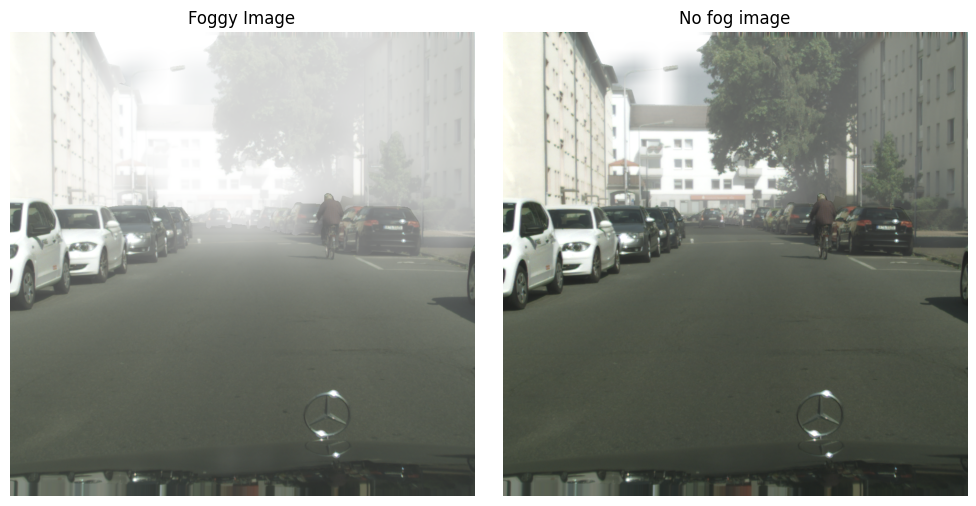

In [22]:
#Claude Opus 3 prompt: how would I view the images from a Dataset class in Pytorch?

img, mask, img_name, lab_name = dataset[0]  # Change the index to view different images
print(img_name)
print("\n")
print(lab_name)

print(img.size())
print(mask.size())
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

#own edits for correct data structure
img = torchvision.transforms.ToPILImage()(img)
mask = torchvision.transforms.ToPILImage()(mask)

# Display the image in the first subplot
ax1.imshow(img)
ax1.set_title('Foggy Image')
ax1.axis('off')

# Display the mask in the second subplot
ax2.imshow(mask)
ax2.set_title('No fog image')
ax2.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()
torch.cuda.empty_cache()

import gc
gc.collect()

5460

In [24]:
#source: https://arxiv.org/pdf/1505.04597v1.pdf

"""
It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by
a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.

At each downsampling step we double the number of feature channels.

Every step in the expansive path consists of an upsampling of the
feature map followed by a 2x2 convolution (“up-convolution”) that halves the
number of feature channels, a concatenation with the correspondingly cropped
feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.

The cropping is necessary due to the loss of border pixels in
every convolution.

At the final layer a 1x1 convolution is used to map each 64-
component feature vector to the desired number of classes. In total the network
has 23 convolutional layers.
"""

class Convblock(nn.Module):

      def __init__(self,input_channel,output_channel,kernel=3,stride=1,padding=1):

        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(input_channel,output_channel,kernel,stride,padding),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel,output_channel,kernel),
            nn.ReLU(inplace=True),
        )

      def forward(self,x):
        x = self.convblock(x)
        return x

In [25]:
class UNet(nn.Module):

    def __init__(self,input_channel,retain=True):

        super().__init__()

        self.conv1 = Convblock(input_channel,32)
        self.conv2 = Convblock(32,64)
        self.conv3 = Convblock(64,128)
        self.conv4 = Convblock(128,256)
        self.neck = nn.Conv2d(256,512,3,1)
        self.upconv4 = nn.ConvTranspose2d(512,256,3,2,0,1)
        self.dconv4 = Convblock(512,256)
        self.upconv3 = nn.ConvTranspose2d(256,128,3,2,0,1)
        self.dconv3 = Convblock(256,128)
        self.upconv2 = nn.ConvTranspose2d(128,64,3,2,0,1)
        self.dconv2 = Convblock(128,64)
        self.upconv1 = nn.ConvTranspose2d(64,32,3,2,0,1)
        self.dconv1 = Convblock(64,32)
        self.out = nn.Conv2d(32,3,1,1)
        self.retain = retain

    def forward(self,x):

        # Encoder Network

        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1,kernel_size=2,stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2,kernel_size=2,stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3,kernel_size=2,stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4,kernel_size=2,stride=2)

        # BottelNeck
        neck = self.neck(pool4)

        # Decoder Network

        # Upconv 1
        upconv4 = self.upconv4(neck)
        croped = self.crop(conv4,upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4,croped],1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        croped = self.crop(conv3,upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3,croped],1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        croped = self.crop(conv2,upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2,croped],1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        croped = self.crop(conv1,upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1,croped],1))
        # Output Layer
        out = self.out(dconv1)

        if self.retain == True:
            out = F.interpolate(out,list(x.shape)[2:])

        return out

    def crop(self,input_tensor,target_tensor):
        # Crops for border kernels
        _,_,H,W = target_tensor.shape
        return transform.CenterCrop([H,W])(input_tensor)

In [26]:
model = UNet(3).float().to(device)

from torchsummary import summary
summary(model, (3,256,256))

epochs = 10

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_acc = []
val_acc = []
train_loss = []
val_loss = []


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 254, 254]           9,248
              ReLU-5         [-1, 32, 254, 254]               0
         Convblock-6         [-1, 32, 254, 254]               0
            Conv2d-7         [-1, 64, 127, 127]          18,496
       BatchNorm2d-8         [-1, 64, 127, 127]             128
              ReLU-9         [-1, 64, 127, 127]               0
           Conv2d-10         [-1, 64, 125, 125]          36,928
             ReLU-11         [-1, 64, 125, 125]               0
        Convblock-12         [-1, 64, 125, 125]               0
           Conv2d-13          [-1, 128, 62, 62]          73,856
      BatchNorm2d-14          [-1, 128,

100%|██████████| 125/125 [04:35<00:00,  2.20s/it]


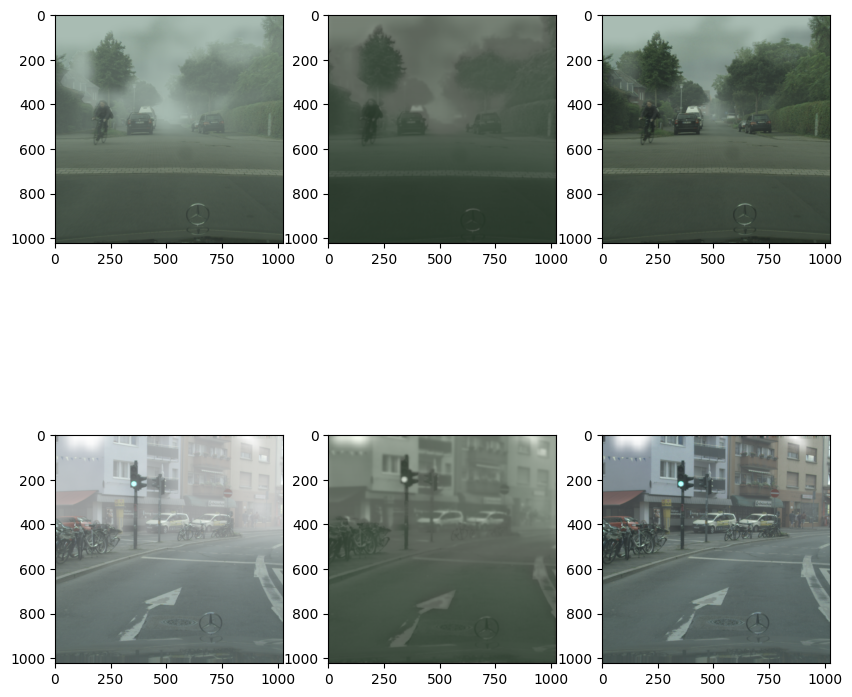

100%|██████████| 500/500 [02:34<00:00,  3.23it/s]


epoch : 1 ,train loss : 0.03652685201913118 ,valid loss : 0.01569097694661468 


100%|██████████| 500/500 [02:34<00:00,  3.24it/s]


epoch : 1 ,train loss : 0.014457587108016014 ,valid loss : 0.01598032967466861 


100%|██████████| 500/500 [02:34<00:00,  3.24it/s]


epoch : 2 ,train loss : 0.013769292272627354 ,valid loss : 0.01602723206859082 


100%|██████████| 500/500 [02:34<00:00,  3.24it/s]


epoch : 3 ,train loss : 0.012949334643781184 ,valid loss : 0.014645563755650074 


100%|██████████| 500/500 [02:34<00:00,  3.23it/s]


epoch : 4 ,train loss : 0.012870348762720822 ,valid loss : 0.014836001187097282 


100%|██████████| 500/500 [02:34<00:00,  3.24it/s]


epoch : 5 ,train loss : 0.012571012496948242 ,valid loss : 0.01757199874985963 


100%|██████████| 500/500 [02:34<00:00,  3.24it/s]


epoch : 6 ,train loss : 0.012212643064558507 ,valid loss : 0.013058839408215134 


100%|██████████| 500/500 [02:33<00:00,  3.25it/s]


epoch : 7 ,train loss : 0.01222228217869997 ,valid loss : 0.015658097854349764 


100%|██████████| 500/500 [02:34<00:00,  3.23it/s]


epoch : 8 ,train loss : 0.011825326539576053 ,valid loss : 0.013906536631286144 


100%|██████████| 500/500 [02:34<00:00,  3.23it/s]

epoch : 9 ,train loss : 0.012169588655233383 ,valid loss : 0.011937936294358223 


In [27]:
for i in range(epochs):

    trainloss = 0
    valloss = 0

    for img,label, img_name, val_name in tqdm(dataloader):
        #print("new image")
        optimizer.zero_grad()
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = loss_func(output,label)
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    if(i%10==0):
      #visualizing the output every 2 epochs
      img_cpu,output_cpu,label_cpu = img.cpu(),output.cpu(),label.cpu()
      fig,ax = plt.subplots(2,3,figsize=(10,10))

      for i in range(2):
        int_img,int_output,int_label = img_cpu[i],output_cpu[i],label_cpu[i]
        int_img,int_output,int_label = int_img,int_output.detach().permute(1,2,0).numpy(),int_label
        ax[i][0].imshow(int_img.permute(1,2,0))
        ax[i][1].imshow(int_output)
        ax[i][2].imshow(int_label.permute(1,2,0))
      plt.show()

    train_loss.append(trainloss/len(dataloader))

    for img,label, img_name, val_name in tqdm(valloader):
        img = img.to(device)
        label = label.to(device)
        output = model(img)
        loss = loss_func(output,label)
        valloss+=loss.item()

    val_loss.append(valloss/len(valloader))

    print("epoch : {} ,train loss : {} ,valid loss : {} ".format(i,train_loss[-1],val_loss[-1]))

In [28]:
torch.save(model, 'model_u_defogger.pth')

In [29]:
import cv2
idx = 0
for img,label, img_name, val_name in tqdm(valloader):
    idx +=1
    img = img.to(device)
    label = label.to(device)
    output = model(img)

    img_cpu = img.cpu()
    output_cpu = output.cpu()
    label_cpu = label.cpu()

    img_to_show = img_cpu.squeeze().numpy()
    img_to_show = np.transpose(img_to_show, (1, 2, 0))

    output_to_show = output_cpu[0].detach().numpy()
    #print(output_to_show.shape)
    output_to_show = np.transpose(output_to_show, (1, 2, 0))

    """
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img_to_show, interpolation='none')
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    # Assuming output is also an image
    plt.imshow(output_to_show, interpolation='none')  # This line may need to change based on the type of output
    plt.title("Model Output")

    plt.show()

    cv2.imwrite("filename.png", img_to_show*225)
    """

    img_filename = os.path.join("/content/in", f"image_{idx}.jpg")
    output_filename = os.path.join("/content/out", f"output_{idx}.jpg")

    cv2.imwrite(img_filename, img_to_show*225)
    cv2.imwrite(output_filename, output_to_show*225)


100%|██████████| 500/500 [02:54<00:00,  2.87it/s]
